# Graph Attention Networks

### Part 0: Set up dependencies

In [1]:
# Check PyTorch version installed on this system
!python -c "import torch; print(torch.__version__)"

1.13.0+cu116


In [2]:
# Download the corresponding PyTorch Geometric module
"""
Assign to TORCH with what you get from the cell above, E.g., export TORCH=1.13.1+cu113
"""
%env TORCH=1.13.0+cu116
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

env: TORCH=1.13.0+cu116
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     |████████████████████████████████| 9.4 MB 8.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
     |████████████████████████████████| 4.5 MB 6.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564 kB 6.9 MB/s 
     |████████████████████████████████| 280 kB 67.2 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=0db035b72d82d28ff83f0a87f835490568b95fd8b80d30ab3142f436b0d23ff6
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c65378
Successfully built torch-geometric
  Att

### Part 1. Oversmoothing

### A. Model Implementation and Training

#### Import required packages

In [3]:
import torch
import os
import typing
import torch_geometric

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.datasets as datasets

from torch_geometric.nn import GATConv, GATv2Conv, JumpingKnowledge
from torch_geometric.utils import dropout_edge

#### Load Cora dataset

In [4]:
dataset = datasets.Planetoid(
    root="./",
    name='Cora',
    split="public",
    transform=torch_geometric.transforms.GCNNorm()
  )

Processing...
Done!


#### Model

In [30]:
class GAT(nn.Module):
  def __init__(
      self,
      input_dim: int,
      hid_dim: int,
      n_classes: int,
      n_layers: int,
      dropout_ratio: float = 0):
    super(GAT, self).__init__()
    """
    Args:
      input_dim: input feature dimension
      hid_dim: hidden feature dimension
      n_classes: number of target classes
      n_layers: number of layers
      dropout_ratio: dropout_ratio
    """

    self.dropout_ratio = dropout_ratio

    self.layers = nn.ModuleList()

    self.gatlast = GATConv(hid_dim, n_classes, dropout=dropout_ratio, concat=False, heads=1)

    # GCN
    if (n_layers > 1):
      self.layers.append(GATConv(input_dim, hid_dim, dropout=dropout_ratio, concat=False, heads=1))
      for i in range(n_layers - 2):
        self.layers.append(GATConv(hid_dim, hid_dim, dropout=dropout_ratio, concat=False, heads=1))

    # elif (n_layers == 1):
    #   self.layers.append(GATConv(input_dim, n_classes, dropout=0.6, concat=False, heads=8))

  def forward(self, X, A) -> torch.Tensor:
    for gcn_layer in self.layers:
      X =  F.elu(gcn_layer(X, A))
    
    X = self.gatlast(X, A)

    logits = F.softmax(X, dim=1)
    return logits    

  def generate_node_embeddings(self, X, A) -> torch.Tensor:
    for gcn_layer in self.layers:
      X = F.elu(gcn_layer(X, A))

    X = F.elu(self.gatlast(X, A))
    return X
  
  def param_init(self):
    pass

#### Training

In [6]:
def train_step(model, data, adj_matrix, loss_fn, optimizer):
  
  model.train()

  pred = model(data.x, adj_matrix)[data.train_mask]
  loss = loss_fn(pred, data.y[data.train_mask])

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  val_accuracy = evaluate(model, data, data.val_mask)
  
  return loss, val_accuracy

In [7]:
def train(
    params: typing.Dict
) -> torch.nn.Module:
  """
    This function trains a node classification model and returns the trained model object.
  """
  # set device
  device = "cuda" if torch.cuda.is_available() else "cpu"

  # load dataset
  data = dataset.data
  data = data.to(device)

  # Update parameters
  params["n_classes"] = dataset.num_classes # number of target classes
  params["input_dim"] = dataset.num_features # size of input features

  # Set a model
  if params['model_name'] == 'GAT':
      model = GAT(
        params["input_dim"], 
        params["hid_dim"],
        params["n_classes"],
        params["n_layers"],
        params["dropout"]
        ).to(device)
  else:
      raise NotImplementedError
  model.param_init()

  adj_matrix = data.edge_index
  if (params["dropedge"]):
    adj_matrix, mask = dropout_edge(data.edge_index, p=params["dropedge_rate"])
  

  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

  train_losses = []
  val_accuracies = []

  # training loop
  
  prev_acc = 100
  cnt = 0

  for step in range(params["epochs"]):
    loss, acc = train_step(model, data, adj_matrix, loss_fn, optimizer)

    if (acc <= prev_acc):
      cnt += 1
    else:
      cnt = 0
    
    prev_acc = acc

    train_losses.append(loss.cpu().detach().numpy())
    val_accuracies.append(acc)
  
  print(val_accuracies[-1])

  return model, train_losses

In [8]:
def evaluate(
    model,
    data,
    mask
):
    adj_matrix = data.edge_index

    y = model(data.x, adj_matrix)[mask]
    y = torch.argmax(y, dim=1)

    accuracy = torch.sum(torch.eq(y, data.y[mask])) / y.shape[0]

    return accuracy

#### Parameters

In [9]:
training_params = {
    "lr": 0.001,  # learning rate
    "weight_decay": 0.005,  # weight_decay
    "epochs": 400,  # number of total training epochs
    "hid_dim": 64, # size of hidden features
    "n_layers": None, # number of layers
    "model_name": "GAT",
    "dropout": 0, # attention dropout rate
    "dropedge": False,
    "dropedge_rate": 0
}

In [10]:
torch.manual_seed(121) # set seed

In [11]:
training_params["n_layers"] = 4
model_4_layer, train_losses_4 = train(training_params)

tensor(0.7180, device='cuda:0')


In [12]:
training_params["n_layers"] = 8
model_8_layer, train_losses_8 = train(training_params)

tensor(0.7460, device='cuda:0')


In [13]:
training_params["n_layers"] = 12
model_12_layer, train_losses_12 = train(training_params)

tensor(0.7480, device='cuda:0')


In [14]:
training_params["n_layers"] = 16
model_16_layer, train_losses_16 = train(training_params)

tensor(0.6720, device='cuda:0')


### B. Visualisation

#### t-SNE

In [15]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
warnings.simplefilter(action='ignore', category=FutureWarning)

In [16]:
def dimension_reduction(model: nn.Module) -> pd.DataFrame:
  """
    Args:
      model: model object for generating features
    
    Return:
      pd.DataFrame: A data frame that has 'dimension 1', 'dimension 2', and 'labels' as a column
  """

  data = dataset.data

  X = model.generate_node_embeddings(data.x, data.edge_index)[data.val_mask]
  X = X.cpu().detach().numpy()
  y = data.y[data.val_mask].cpu().detach().numpy().reshape((X.shape[0], 1))
  X_embedded = TSNE(n_components=2, learning_rate='auto',
                      init='random', perplexity=10).fit_transform(X)
  X_embedded = np.concatenate([X_embedded, y], axis=1)
  
  df = pd.DataFrame(X_embedded, columns = ['dimension 1', 'dimension 2', 'labels'])

  return df

In [17]:
feature_dict = {
    "4_layer": dimension_reduction(model_4_layer),
    "8_layer": dimension_reduction(model_8_layer),
    "12_layer": dimension_reduction(model_12_layer),
    "16_layer": dimension_reduction(model_16_layer)
}

In [18]:
def visualise(feature_dict: typing.Dict) -> None:
    fig, ax = plt.subplots(1, 4, sharey=True, sharex=True, figsize=(16,4))

    i = 0
    for k in feature_dict.keys():
      df = feature_dict[k]
      ax[i].scatter(df[['dimension 1']], df[['dimension 2']], c=df['labels'].tolist(), s=5)
      i += 1

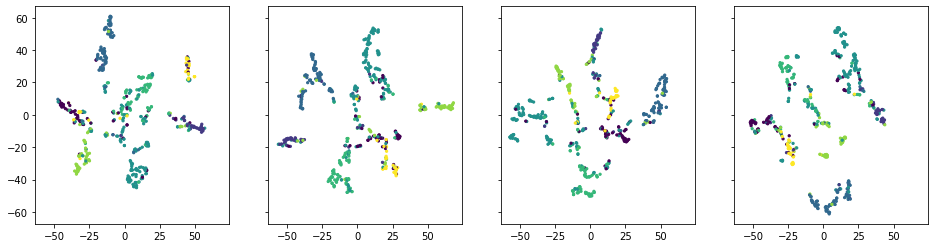

In [19]:
visualise(feature_dict)

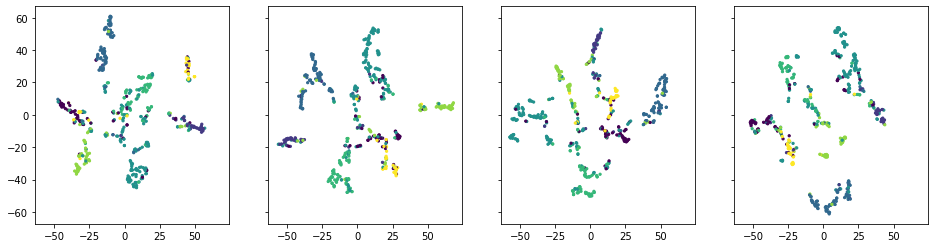

In [20]:
visualise(feature_dict)

#### Average embedding distance

In [21]:
def distance(model: nn.Module):
  data = dataset.data
  X = model.generate_node_embeddings(data.x, data.edge_index)[data.val_mask]
  X = X.cpu().detach().numpy()

  distances = np.linalg.norm(X[:, np.newaxis] - X, axis=-1)

  np.fill_diagonal(distances, np.nan)


  average_distance = np.nanmean(distances)
  return average_distance

In [22]:
n_layer = [4, 8, 12, 16]
n_dist = [distance(model_4_layer),
          distance(model_8_layer),
          distance(model_12_layer),
          distance(model_16_layer)]

In [23]:
n_dist

[11.811848, 19.876394, 22.228037, 23.362934]

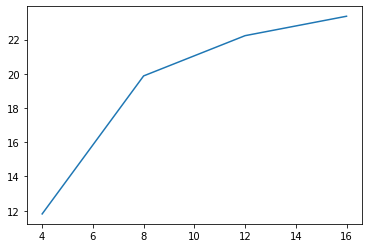

In [24]:
plt.plot(n_layer, n_dist)

In [25]:
n_dist2 = [distance(model_4_layer),
          distance(model_8_layer),
          distance(model_12_layer),
          distance(model_16_layer)]

In [26]:
n_dist2

[11.811848, 19.876394, 22.228037, 23.362932]

In [27]:
n_dist3 = [distance(model_4_layer),
          distance(model_8_layer),
          distance(model_12_layer),
          distance(model_16_layer)]

In [28]:
n_dist3

[11.811848, 19.876394, 22.228037, 23.362934]

Text(0.5, 1.0, 'Average embedding distance')

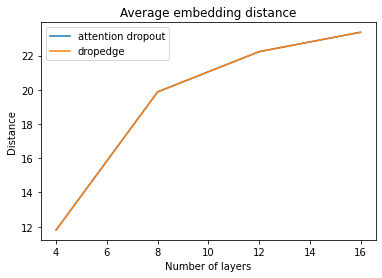

In [29]:
plt.plot(n_layer, n_dist2, label="attention dropout")
plt.plot(n_layer, n_dist3, label="dropedge")
plt.xlabel("Number of layers")
plt.ylabel("Distance")
plt.legend()
plt.title('Average embedding distance')